## Recommender system using collaborative filtering.
Welcome! 

In this notebook I will walk through a simple implemenation of a collaborative filtering algorithm which is capable of recommending movies to users. All the predictions will be based on the personal preferences of the individuals in the dataset.

### Importing the data

First step is to import the data. For this project I will be using the MovieLens dataset which contains 100 000 movies and user rankings.

In [5]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [6]:
path = untar_data(URLs.ML_100k)

Since the csv file does not contain any colum names, we can add them very simply using the names parameter.  

#REFACTOR

In [7]:
df = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])

df.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


After a short overview of the dataframe we can see that the movie is depicted by id. For easier interpretability it is suitable to merge this dataframe with one contating the movie titles. 

In [8]:
movie_titles = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

df = df.merge(movie_titles)
df

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1994)"


### The approach

To tackle this task, we have to follow a simple four step process.

1. Randomly initialize a set of parameters. These are called the latent factors and are assigned to each movie and user. 
2. Calculate the predictions. This can be achieved simply by computing the dot product of each movie and each user. 
3. Calculate the loss. Any loss function is suitable for this step. For simplicity stake I choose mean squared error.
4. Optimize the parameters (the latent factors) using Stochastic gradient descend. 

In each iteration, the stochastic gradient descent optimizer assesses the alignment between every movie and user by employing the dot product. It then contrasts this result with the respective ratings given by users to each movie. The optimizer subsequently computes the derivative of this contrast and adjusts the weights by scaling this derivative with the learning rate. Through numerous iterations of this process, the model's loss improves progressively, leading to increasingly refined movie recommendations.


#REFACTOR




 

   
    

In [9]:
## Dataloaders
dls = CollabDataLoaders.from_df(df, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [10]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

**Explaining Embeddings**

The problem we need to solve is looking up indexes of movies in the movie latent factor matrix, and the index of the index of the user in our user latent factor matrix. Afterwards we can compute the dot product between the two latent factors.

To achieve this, we can construct a one-hot encoded vector of the indices. If we do that enough times we will get an matrix of one hot encoded vectors and the operation would be a matrix multiplication. This would work, but would use too much memory and time. We understand that there is no genuine need to retain the one-hot-encoded vector or to navigate through it to identify the presence of the number one. Ideally, we should be able to directly access an array using an integer index. Consequently, many deep learning frameworks, PyTorch included, incorporate a dedicated layer for this purpose. This layer efficiently accesses a vector using an integer index, and its derivative computation mirrors what would have resulted from a matrix multiplication with a one-hot-encoded vector. This specialized layer is commonly referred to as an embedding.

Simply put, and embedding is multiplying by a one-hot encoded matrix, using the computational shortcut that it can be implemented by indexing directly. 


In [11]:
class DotProduct(Module):
    def __init__(self,n_users, n_movies, n_factors):
        super().__init__()
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)
        

In [12]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [13]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.370162,1.313121,00:12
1,1.095348,1.090943,00:12
2,0.984061,1.004893,00:12
3,0.858839,0.908917,00:11
4,0.769006,0.891355,00:11


### Adding Biases

Our model is working! This is a good start but so far our dot product representation lacks the ability to distingiush between good and bad movies. Furhtemore, some users are more critical and some are more positive in their ratings. Since we are only using latent factors so far (without biases) our model is not able to do that. 

To change that we can add movie and user biases simply by creating new embedings. We will also change the forward method adding the biases to the result we'll return.

In [14]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [15]:
model2 = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model2, loss_func=MSELossFlat())

In [16]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.926176,0.937674,00:12
1,0.813878,0.861336,00:14
2,0.613595,0.868241,00:11
3,0.410079,0.891053,00:11
4,0.289558,0.897839,00:12


### Validation loss increasing?

What happened? Throughout the training of our model the validation loss started to increase after the first epoch. This is a clear sign of overfitting. Because there is no otpion for us to augment the data we have to pick another approach. 

A simple regularization technique we can use is called weight decay.

In short, weight decay penalizes large weights in the network. It achieves this by adding a term to the loss function that is proportional to the sum of the squared weights.

How does it work?

We know that the larger the coefficients are, the sharper the canyons are in the loss function. This means, that letting our model train on high coeficients can cause it to fit all the data points in the training set with that overcomplicated function (which has very sharp edges). This in result leads to overfitting.

To achieve that we will add the sum of all the weights squared to our loss function.

`loss += weight_decay * (parameters**2).sum()`




In [17]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.962487,0.950873,00:11
1,0.855566,0.885126,00:12
2,0.757869,0.838936,00:11
3,0.577863,0.823613,00:11
4,0.495438,0.824926,00:12


Lets see how it compares to OpenAi's built in learner:

In [50]:
learner = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.553635,0.862219,00:10
1,0.602796,0.870393,00:11
2,0.533422,0.863728,00:10
3,0.410874,0.859889,00:11
4,0.294017,0.862167,00:11


### Model interpretation

Having successfully trained a model we can now procede and takea closer look at the weights and biases. 

We can start by selecting the 1000 highest rated movies of the dataset.

In [92]:
rating_sum = df.groupby('title')['rating'].count()
best_movies = rating_sum.sort_values(ascending=False).index.values[:1000]
best_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

**movie biases**

Lets first take a look at the biases which our model has worked out. 

In [93]:
movie_bias = learner.model.bias(best_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

We can now compare those biases with the average ratings.

In [94]:
mean_ratings = df.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(best_movies,movie_bias)]

In [95]:
# movies with worst bias
sorted(movie_ratings, key = lambda o:o[0])[:15]

[(tensor(-0.0199), 'Dazed and Confused (1993)', 3.46875),
 (tensor(-0.0197), 'Apple Dumpling Gang, The (1975)', 2.84),
 (tensor(-0.0197), 'Twelve Monkeys (1995)', 3.798469387755102),
 (tensor(-0.0193), 'Basketball Diaries, The (1995)', 3.425),
 (tensor(-0.0192), 'Mallrats (1995)', 3.4444444444444446),
 (tensor(-0.0188), "Eve's Bayou (1997)", 3.609375),
 (tensor(-0.0188), 'James and the Giant Peach (1996)', 3.126984126984127),
 (tensor(-0.0188),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
  4.252577319587629),
 (tensor(-0.0184),
  "Romy and Michele's High School Reunion (1997)",
  3.061224489795918),
 (tensor(-0.0183), 'Star Trek: Generations (1994)', 3.336206896551724),
 (tensor(-0.0182), 'My Fellow Americans (1996)', 3.1627906976744184),
 (tensor(-0.0182), 'Sound of Music, The (1965)', 3.765765765765766),
 (tensor(-0.0182), 'Ghosts of Mississippi (1996)', 3.4827586206896552),
 (tensor(-0.0180), 'Grand Day Out, A (1992)', 4.106060606060606),
 (tenso

In [96]:
# Movies with highest bias
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.0197), 'Die Hard (1988)', 3.8724279835390947),
 (tensor(0.0197), 'Victor/Victoria (1982)', 3.3376623376623376),
 (tensor(0.0196), 'Full Metal Jacket (1987)', 3.6823529411764704),
 (tensor(0.0195), 'Aristocats, The (1970)', 3.1296296296296298),
 (tensor(0.0195), 'In the Mouth of Madness (1995)', 2.8846153846153846),
 (tensor(0.0192), 'Inspector General, The (1949)', 3.7222222222222223),
 (tensor(0.0192), 'Rudy (1993)', 3.3125),
 (tensor(0.0192), 'Glimmer Man, The (1996)', 2.75),
 (tensor(0.0190), 'Much Ado About Nothing (1993)', 4.0625),
 (tensor(0.0190), 'Little Princess, A (1995)', 3.658536585365854),
 (tensor(0.0189), 'Graduate, The (1967)', 4.104602510460251),
 (tensor(0.0188), 'Grumpier Old Men (1995)', 3.0405405405405403),
 (tensor(0.0187), 'Get on the Bus (1996)', 3.3157894736842106),
 (tensor(0.0186), 'Assignment, The (1997)', 3.5),
 (tensor(0.0186), 'Quiet Man, The (1952)', 4.029850746268656)]

As we can notice, the correlation is very high. Furthermore, the bias tells us something more about the movies. Low bias for example represents, that even though the user is matched well with the latent factors of the movie, they will not enjoy it. However, regarding the movies with the highest biases, even if a person would typically not enjoy action movies such as 'Die Hard', there is a high chance that it will be to their liking.

 **Movie weights**
 
 Lets analyze the movie weights of our model.

In [106]:
movie_w = learner.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

To reduce the dimensions, I will apply principal component analysis.
To learn more about the functionality behind PCA i recommend this guide: https://www.keboola.com/blog/pca-machine-learning

In [107]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [108]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Lets take a look at the highest and lowest scores along the first dimension respectively:

In [111]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.0315), 'Spawn (1997)'),
 (tensor(0.0313), "McHale's Navy (1997)"),
 (tensor(0.0280), 'Howling, The (1981)'),
 (tensor(0.0275), 'Rosencrantz and Guildenstern Are Dead (1990)'),
 (tensor(0.0255), 'Eat Drink Man Woman (1994)'),
 (tensor(0.0240), 'Tales from the Hood (1995)'),
 (tensor(0.0234), 'Sex, Lies, and Videotape (1989)'),
 (tensor(0.0233), 'Platoon (1986)'),
 (tensor(0.0232), 'Scream 2 (1997)'),
 (tensor(0.0231), 'When Harry Met Sally... (1989)')]

In [112]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.0294), "Eve's Bayou (1997)"),
 (tensor(-0.0292), 'Belle de jour (1967)'),
 (tensor(-0.0278), 'Quiet Man, The (1952)'),
 (tensor(-0.0271), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.0244), 'Star Trek: The Wrath of Khan (1982)'),
 (tensor(-0.0233), 'Only You (1994)'),
 (tensor(-0.0233), 'My Left Foot (1989)'),
 (tensor(-0.0231), 'Volcano (1997)'),
 (tensor(-0.0227), 'Cliffhanger (1993)'),
 (tensor(-0.0227), 'Blue in the Face (1995)')]

Similairly, we can look inside the second dimension to see what our model has learned. Once again worst and best scores are depicted respectively.

In [114]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [115]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.0310), 'Candyman (1992)'),
 (tensor(-0.0305), 'Terminator, The (1984)'),
 (tensor(-0.0268), 'Koyaanisqatsi (1983)'),
 (tensor(-0.0267), 'Saint, The (1997)'),
 (tensor(-0.0261), 'Kansas City (1996)'),
 (tensor(-0.0248), 'Adventures of Pinocchio, The (1996)'),
 (tensor(-0.0247), 'Beautiful Thing (1996)'),
 (tensor(-0.0244), 'Batman & Robin (1997)'),
 (tensor(-0.0238), 'Under Siege (1992)'),
 (tensor(-0.0237), 'Around the World in 80 Days (1956)')]

In [116]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.0336), 'Escape from New York (1981)'),
 (tensor(0.0315), 'Grumpier Old Men (1995)'),
 (tensor(0.0302), "Mr. Holland's Opus (1995)"),
 (tensor(0.0273), 'Blood & Wine (1997)'),
 (tensor(0.0272), 'Chungking Express (1994)'),
 (tensor(0.0267), 'That Darn Cat! (1997)'),
 (tensor(0.0257), 'Bean (1997)'),
 (tensor(0.0247), 'High Noon (1952)'),
 (tensor(0.0246), 'Sleepless in Seattle (1993)'),
 (tensor(0.0233), 'Wild Bunch, The (1969)')]

Finally, we can take a look at a representation of what our model has learned based on two of the strongest PCA components.

It looks like our model learned to distingiush between classic and pop culture movies. It successfully groups together movies that are similar. 

Quite incredible when we think about it, that without giving the model any instructions it managed to discover such things from the data.



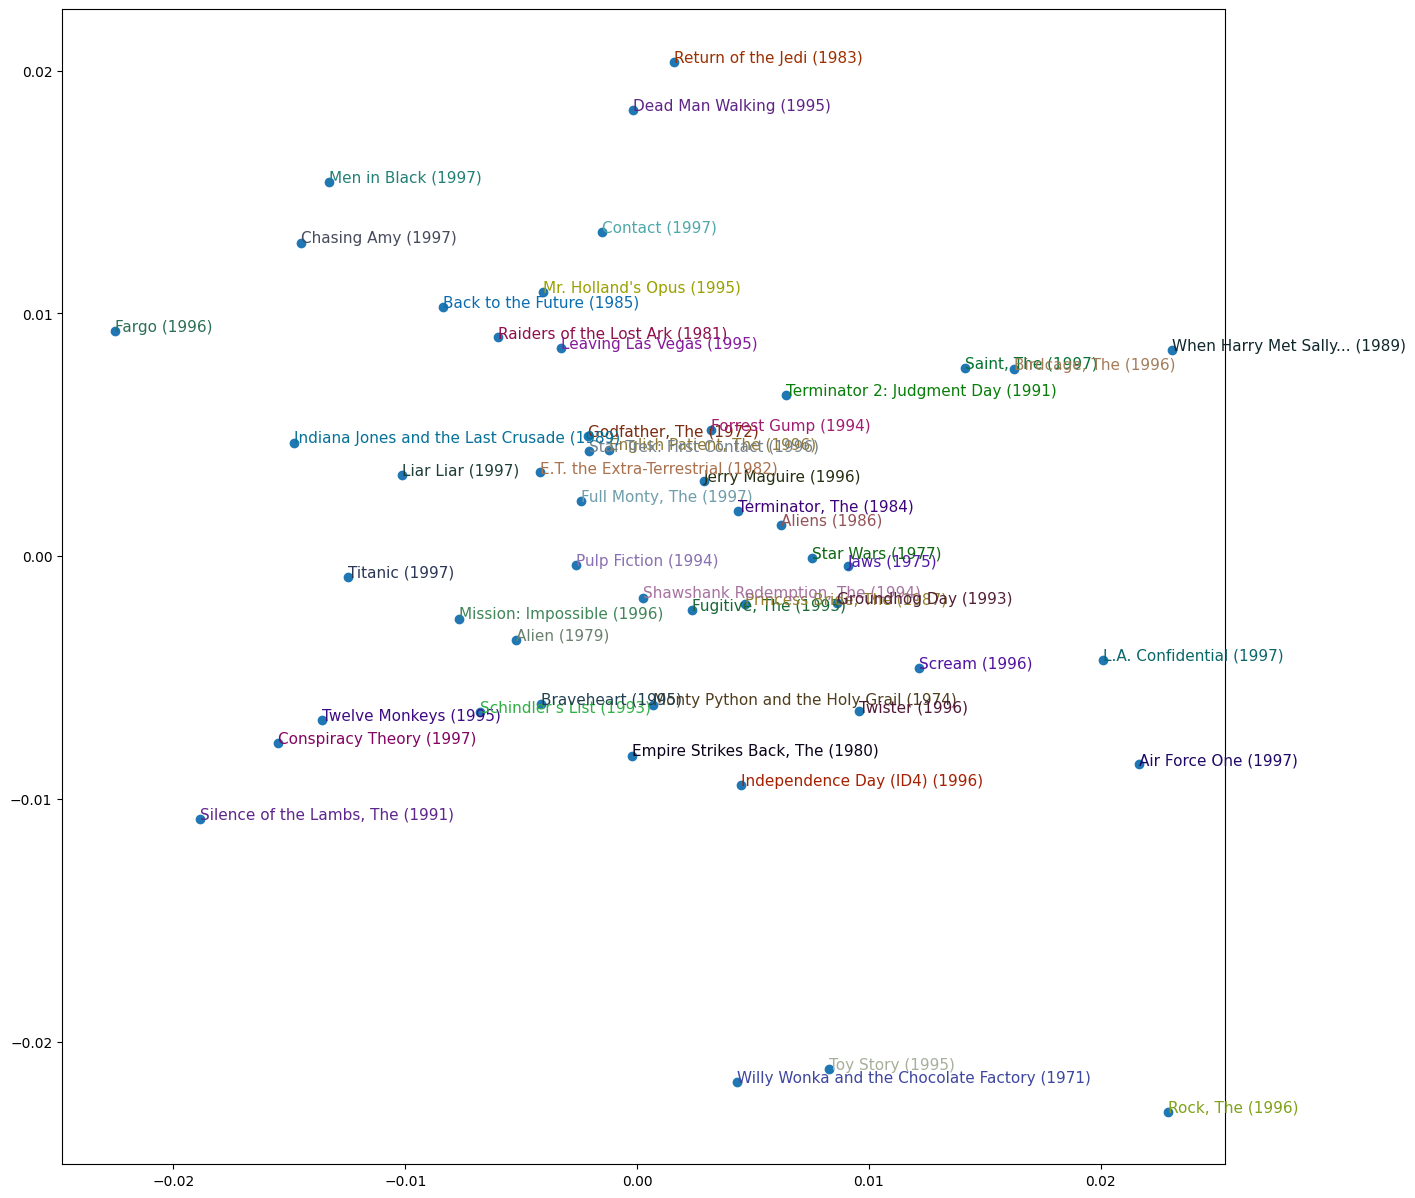

In [120]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()